In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [2]:
# 1. 加载数据
file_path = r'D:\Pythonworkshop\Solar_data_processing\cleaned_data_final_Yulara.csv'
data = pd.read_csv(file_path)

# 删除时间戳列
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# 添加前一时刻的功率数据作为新的特征
data['Prev_Power'] = data['Active_Power'].shift(1)
data['Prev_Power'] = data['Prev_Power'].fillna(0)  # 处理缺失值

# 数据集划分
X = data.drop(columns=['Active_Power'])
y = data['Active_Power']

# 假设 X 和 y 是你的特征和标签数据
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


# 使用训练集数据进行归一化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 仅使用训练集数据拟合scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 使用训练集的归一化参数对验证集和测试集进行归一化
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [3]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr  # 直接返回 lr
    else:
        return lr * tf.math.exp(-0.1).numpy()  # 计算新的学习率并转换为浮点数

# 创建 LearningRateScheduler 回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)



# 创建 EarlyStopping 回调
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证集损失
    patience=30,         # 在10个epoch后停止，如果val_loss没有改进
    verbose=1,
    restore_best_weights=True  # 恢复最佳模型的权重
)

In [34]:
class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', trainable=True)
        self.W_rec = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', trainable=True)
        
        # 动态时间常数的权重矩阵
        self.W_tau = self.add_weight(shape=(input_size + hidden_size, hidden_size), initializer='random_normal', trainable=True)
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus  # 使用 softplus 激活函数确保时间常数为正

    def call(self, inputs, state):
        # 计算新的状态
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        
        # 将输入和当前状态连接，用于计算动态时间常数
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        
        # 使用动态时间常数更新状态
        state = state + (1.0 / tau) * (new_state - state)
        return state

class LNNModel(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super(LNNModel, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size)
        self.fc = layers.Dense(output_size)

    def call(self, inputs):
        state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        state = self.lnn_layer(inputs, state)
        output = self.fc(state)
        return output

# 模型参数
input_size = X_train_scaled.shape[1]
hidden_size = 90
output_size = 1

# 构建模型
lnn_model = LNNModel(input_size, hidden_size, output_size)

# 编译模型
lnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

history_lnn = lnn_model.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[lr_scheduler, early_stopping]  # 添加回调
)

# 测试模型
y_pred_lnn_scaled = lnn_model.predict(X_test_scaled)
y_pred_lnn = scaler_y.inverse_transform(y_pred_lnn_scaled)


Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 0.0676 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - loss: 0.0107 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 0.0099 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 0.0091 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 0.0089 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.0087 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 0.0087 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.0079 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.0081 - val_lo

In [35]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 构建 SVM 模型
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# 训练 SVM 模型
svm_model.fit(X_train, y_train)

# 测试 SVM 模型
y_pred_svm = svm_model.predict(X_test)

In [37]:
import tensorflow as tf
from tensorflow.keras import  regularizers

class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(
            shape=(input_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.W_rec = self.add_weight(
            shape=(hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg), 
            trainable=True
        )
        self.W_tau = self.add_weight(
            shape=(input_size + hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        state = state + (1.0 / tau) * (new_state - state)
        state = self.norm(state)  # 归一化
        return state

class DynamicTimeConstantGRU(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(DynamicTimeConstantGRU, self).__init__()
        self.hidden_size = hidden_size
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_tau = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_tau = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.b_tau = self.add_weight(shape=(hidden_size,), initializer='zeros', trainable=True)
        self.activation = tf.nn.tanh
        self.sigmoid = tf.nn.sigmoid
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        r_t = self.sigmoid(tf.matmul(inputs, self.W_r) + tf.matmul(state, self.U_r))
        z_t = self.sigmoid(tf.matmul(inputs, self.W_z) + tf.matmul(state, self.U_z))
        h_tilde = self.activation(tf.matmul(inputs, self.W_h) + r_t * tf.matmul(state, self.U_h))
        tau_t = self.tau_activation(tf.matmul(inputs, self.W_tau) + tf.matmul(state, self.U_tau) + self.b_tau)
        new_state = state + (1.0 / tau_t) * (z_t * (h_tilde - state))
        new_state = self.norm(new_state)  # 归一化
        return new_state

class LNNGRUModelWithDropout(tf.keras.Model):
    def __init__(self, input_size, hidden_size_GRU, hidden_size_RNN, output_size, l2_reg, dropout_rate):
        super(LNNGRUModelWithDropout, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size_RNN, l2_reg=l2_reg)
        self.dynamic_gru_layer = DynamicTimeConstantGRU(input_size, hidden_size_GRU, l2_reg=l2_reg)
        #self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_size, kernel_regularizer=regularizers.l2(l2_reg))

    def call(self, inputs):
        lnn_state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        lnn_output = self.lnn_layer(inputs, lnn_state)

        gru_state = tf.zeros((tf.shape(inputs)[0], self.dynamic_gru_layer.hidden_size))
        gru_output = self.dynamic_gru_layer(inputs, gru_state)

        combined_output = tf.concat([lnn_output, gru_output], axis=-1)
        #dropped_output = self.dropout(combined_output)
        output = self.fc(combined_output)
        return output
# 构建模型
input_size = X_train_scaled.shape[1]
hidden_size_GRU = 32
hidden_size_RNN = 128
l2_r = 0.0001
dropout_rate = 0.2
output_size = 1
TCLNNGRU_model =LNNGRUModelWithDropout(input_size, hidden_size_GRU, hidden_size_RNN, output_size,l2_r, dropout_rate)

# 编译模型
TCLNNGRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0011910613648780674), loss='mse')

# 训练模型
TCLNNGRU_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, validation_data=(X_val_scaled, y_val_scaled),callbacks=[lr_scheduler, early_stopping])

# 测试模型
y_pred_tclnngru_scaled = TCLNNGRU_model.predict(X_test_scaled)
y_pred_tclnngru = scaler_y.inverse_transform(y_pred_tclnngru_scaled)

Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0586 - val_loss: 0.0189 - learning_rate: 0.0012
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0119 - val_loss: 0.0180 - learning_rate: 0.0012
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112 - val_loss: 0.0151 - learning_rate: 0.0012
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0105 - val_loss: 0.0154 - learning_rate: 0.0012
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0102 - val_loss: 0.0157 - learning_rate: 0.0012
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0106 - val_loss: 0.0135 - learning_rate: 0.0012
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - val_loss: 0.0126 - learning_rate: 0.0012
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095 - val_loss: 0.0134 - learning_rate: 0.0012
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0088 - val_loss: 0.0121 - learn

In [ ]:
class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(
            shape=(input_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.W_rec = self.add_weight(
            shape=(hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg), 
            trainable=True
        )
        self.W_tau = self.add_weight(
            shape=(input_size + hidden_size, hidden_size), 
            initializer='random_normal', 
            regularizer=regularizers.l2(l2_reg),
            trainable=True
        )
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        state = state + (1.0 / tau) * (new_state - state)
        state = self.norm(state)  # 归一化
        return state

class DynamicTimeConstantGRU(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(DynamicTimeConstantGRU, self).__init__()
        self.hidden_size = hidden_size
        self.W_r = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_r = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_z = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_z = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_h = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_h = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.W_tau = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.U_tau = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', regularizer=regularizers.l2(l2_reg), trainable=True)
        self.b_tau = self.add_weight(shape=(hidden_size,), initializer='zeros', trainable=True)
        self.activation = tf.nn.tanh
        self.sigmoid = tf.nn.sigmoid
        self.tau_activation = tf.nn.softplus
        self.norm = layers.BatchNormalization()  # 添加归一化层

    def call(self, inputs, state):
        r_t = self.sigmoid(tf.matmul(inputs, self.W_r) + tf.matmul(state, self.U_r))
        z_t = self.sigmoid(tf.matmul(inputs, self.W_z) + tf.matmul(state, self.U_z))
        h_tilde = self.activation(tf.matmul(inputs, self.W_h) + r_t * tf.matmul(state, self.U_h))
        tau_t = self.tau_activation(tf.matmul(inputs, self.W_tau) + tf.matmul(state, self.U_tau) + self.b_tau)
        new_state = state + (1.0 / tau_t) * (z_t * (h_tilde - state))
        new_state = self.norm(new_state)  # 归一化
        return new_state
    
class ResidualLNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(ResidualLNNLayer, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size, l2_reg)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, state):
        lnn_output = self.lnn_layer(inputs, state)
        lnn_output = self.norm(lnn_output)
        return layers.add([state, lnn_output])  # 添加残差连接

class ResidualGRULayer(layers.Layer):
    def __init__(self, input_size, hidden_size, l2_reg):
        super(ResidualGRULayer, self).__init__()
        self.gru_layer = DynamicTimeConstantGRU(input_size, hidden_size, l2_reg)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, state):
        gru_output = self.gru_layer(inputs, state)
        gru_output = self.norm(gru_output)
        return layers.add([state, gru_output])  # 添加残差连接

class LNNGRUModelWithResiduals(tf.keras.Model):
    def __init__(self, input_size, hidden_size_GRU, hidden_size_LNN, l2_reg, num_residual_blocks, output_size):
        super(LNNGRUModelWithResiduals, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size_LNN, l2_reg)
        self.dynamic_gru_layer = DynamicTimeConstantGRU(input_size, hidden_size_GRU, l2_reg)
        self.residual_lnn_layers = [ResidualLNNLayer(input_size, hidden_size_LNN, l2_reg) for _ in range(num_residual_blocks)]
        self.residual_gru_layers = [ResidualGRULayer(input_size, hidden_size_GRU, l2_reg) for _ in range(num_residual_blocks)]
        self.fc = layers.Dense(output_size, kernel_regularizer=regularizers.l2(l2_reg))

    def call(self, inputs):
        lnn_state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        gru_state = tf.zeros((tf.shape(inputs)[0], self.dynamic_gru_layer.hidden_size))

        lnn_output = self.lnn_layer(inputs, lnn_state)
        gru_output = self.dynamic_gru_layer(inputs, gru_state)

        for layer in self.residual_lnn_layers:
            lnn_output = layer(inputs, lnn_output)

        for layer in self.residual_gru_layers:
            gru_output = layer(inputs, gru_output)

        combined_output = tf.concat([lnn_output, gru_output], axis=-1)
        output = self.fc(combined_output)
        return output

# 模型参数
input_size = X_train_scaled.shape[1]
hidden_size_GRU = 32
hidden_size_LNN = 96
l2_reg = 0.000103
num_residual_blocks = 2  # 设置残差块的数量
output_size = 1

# 创建模型实例
model_rd = LNNGRUModelWithResiduals(input_size, hidden_size_GRU, hidden_size_LNN, l2_reg, num_residual_blocks, output_size)

# 编译、训练和测试模型
model_rd.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000786), loss='mse')
model_rd.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, validation_data=(X_val_scaled, y_val_scaled),callbacks=[lr_scheduler, early_stopping])

y_pred_residual_tclnngru_scaled = model_rd.predict(X_test_scaled)
y_pred_residual_tclnngru = scaler_y.inverse_transform(y_pred_residual_tclnngru_scaled)

Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0844 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0286 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0207 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0157 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0129 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0113 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0100 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0087 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0087 - val_loss: 0.0125 - lear

In [ ]:
lstm_model = models.Sequential([
    layers.LSTM(90, input_shape=(X_train_scaled.shape[1], 1)),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# 训练模型
lstm_model.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train_scaled, epochs=100, batch_size=64, validation_data=(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val_scaled),callbacks=[lr_scheduler, early_stopping])

# 测试模型
y_pred_lstm_scaled = lstm_model.predict(X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1))
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)


Epoch 1/100


c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1403 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0136 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0131 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0122 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0115 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0104 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0101 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0095 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0089 - val_loss: 0.0162 - learning_rate: 0.

In [ ]:
gru_model = models.Sequential([
    layers.GRU(90, input_shape=(X_train_scaled.shape[1], 1)),
    layers.Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

# 训练模型
gru_model.fit(X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1), y_train_scaled, epochs=100, batch_size=64, validation_data=(X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1), y_val_scaled),callbacks=[lr_scheduler, early_stopping])

# 测试模型
y_pred_gru_scaled = gru_model.predict(X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1))
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)


Epoch 1/100


c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1599 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0128 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0130 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0129 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0112 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0104 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0095 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0089 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0086 - val_loss: 0.0145 - learning_rate: 0.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 测试模型
y_pred_rf = rf_model.predict(X_test)


In [ ]:
catboost_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, silent=True)

# 训练模型
catboost_model.fit(X_train, y_train)

# 测试模型
y_pred_catboost = catboost_model.predict(X_test)


In [ ]:
models_predictions = {
    'LNN': y_pred_lnn,
    'SVM': y_pred_svm,
    'TCLNNGRU': y_pred_tclnngru,
    'ResidualTCLNNGRU': y_pred_residual_tclnngru,
    'LSTM': y_pred_lstm,
    'GRU': y_pred_gru,
    'RandomForest': y_pred_rf,
    'CatBoost': y_pred_catboost
}

results = []

for model_name, y_pred in models_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results.append({'Model': model_name, 'RMSE': rmse, 'MAPE': mape})

results_df = pd.DataFrame(results)
results_df.to_csv('model_comparison_results.csv', index=False)


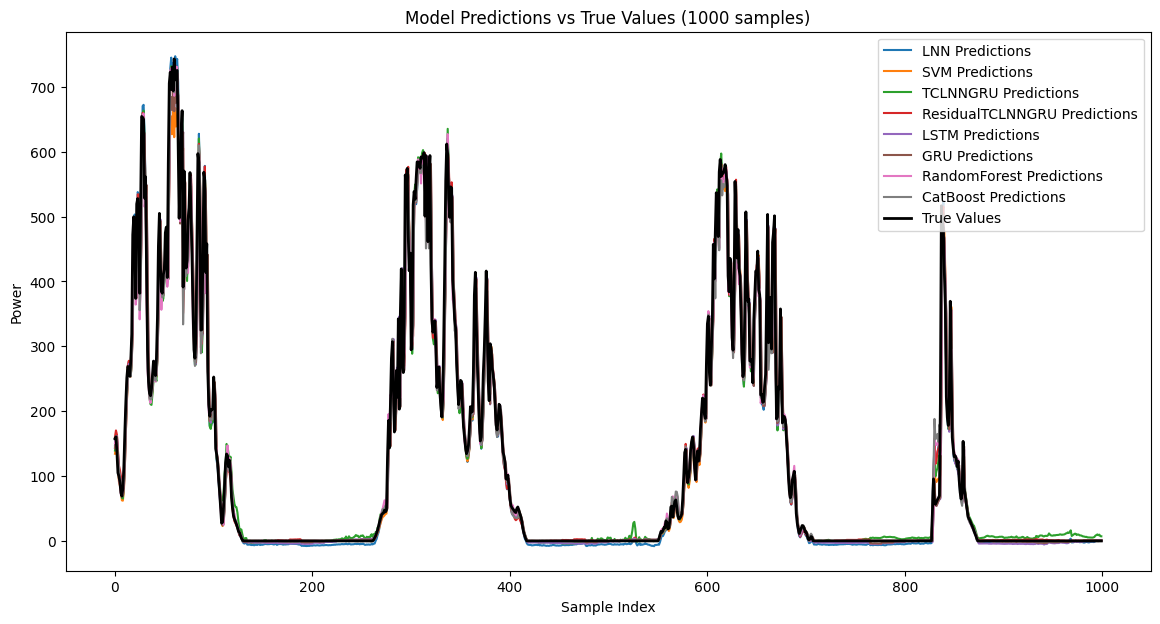

In [ ]:
plt.figure(figsize=(14, 7))

# 选取1000个点
sample_range = range(1000)

for model_name, y_pred in models_predictions.items():
    plt.plot(sample_range, y_pred[:1000], label=f'{model_name} Predictions')

plt.plot(sample_range, y_test.values[:1000], label='True Values', color='black', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('Power')
plt.title('Model Predictions vs True Values (1000 samples)')
plt.legend()
plt.savefig('model_predictions_comparison.png')
plt.show()


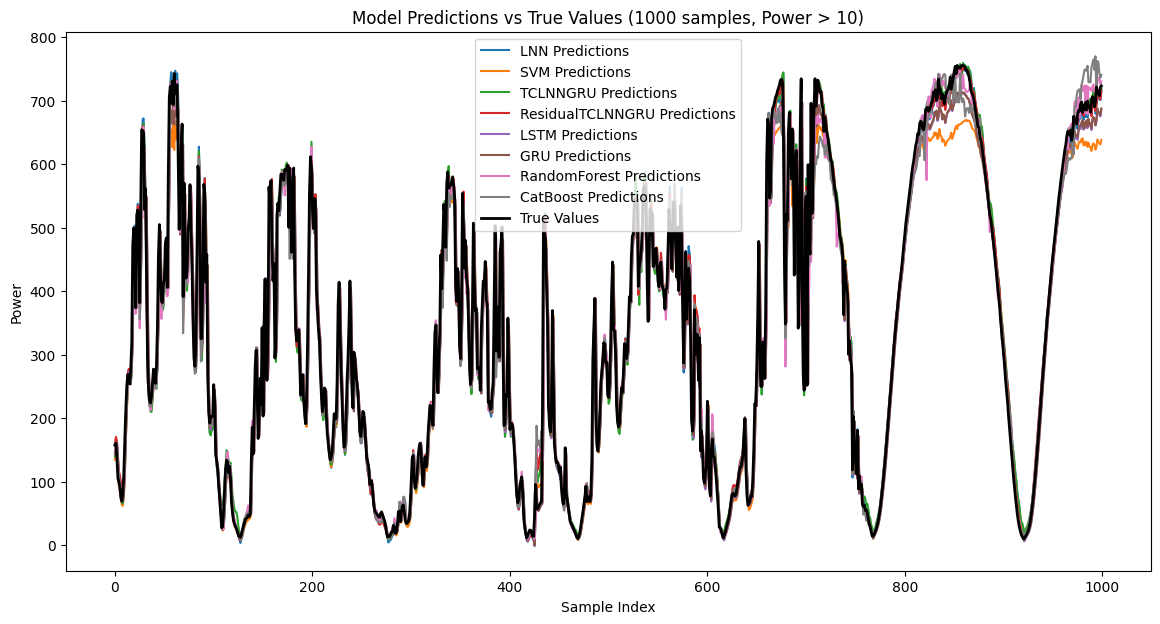

In [ ]:
# 筛选目标列（功率列）值大于10的数据
mask = y_test > 10
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

# 同样筛选出对应的预测结果
models_predictions_filtered = {
    'LNN': y_pred_lnn[mask],
    'SVM': y_pred_svm[mask],
    'TCLNNGRU': y_pred_tclnngru[mask],
    'ResidualTCLNNGRU': y_pred_residual_tclnngru[mask],
    'LSTM': y_pred_lstm[mask],
    'GRU': y_pred_gru[mask],
    'RandomForest': y_pred_rf[mask],
    'CatBoost': y_pred_catboost[mask]
}
filtered_results = []

for model_name, y_pred in models_predictions_filtered.items():
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred))
    mape = mean_absolute_percentage_error(y_test_filtered, y_pred)
    filtered_results.append({'Model': model_name, 'RMSE (Power > 10)': rmse, 'MAPE (Power > 10)': mape})

filtered_results_df = pd.DataFrame(filtered_results)
filtered_results_df.to_csv('model_comparison_results_power_gt_10.csv', index=False)
plt.figure(figsize=(14, 7))

# 选取前1000个点并且功率值大于10的数据
sample_range = np.arange(len(y_test_filtered))[:1000]

for model_name, y_pred in models_predictions_filtered.items():
    plt.plot(sample_range, y_pred[:1000], label=f'{model_name} Predictions')

plt.plot(sample_range, y_test_filtered.values[:1000], label='True Values', color='black', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('Power')
plt.title('Model Predictions vs True Values (1000 samples, Power > 10)')
plt.legend()
plt.savefig('model_predictions_comparison_power_gt_10.png')
plt.show()


In [ ]:
# 创建保存预测结果的DataFrame
predictions_df = pd.DataFrame({
    'True Values': y_test.values.flatten(),
    'LNN Predictions': y_pred_lnn.flatten(),
    'SVM predictions': y_pred_svm.flatten(),
    'TCLNNGRU Predictions': y_pred_tclnngru.flatten(),
    'Residual LNNGRU Predictions':y_pred_residual_tclnngru.flatten(),
    'LSTM Predictions': y_pred_lstm.flatten(),
    'GRU Predictions': y_pred_gru.flatten(),
    'RandomForest Predictions': y_pred_rf.flatten(),
    'CatBoost Predictions': y_pred_catboost.flatten()
})

# 保存到CSV文件
predictions_df.to_csv('all_model_predictions.csv', index=False)


   True Values  LNN Predictions  SVM predictions  TCLNNGRU Predictions  \
0   157.646347        147.19281       134.313690             139.32558   
1   160.447708        160.25818       146.167797             151.17088   
2   135.842972        156.68076       141.371449             147.98502   
3   104.961761        129.23062       114.573954             122.29082   
4    99.600632        101.74664        91.368357              96.67719   

   Residual LNNGRU Predictions  LSTM Predictions  GRU Predictions  \
0                   160.195800         144.20859       143.051700   
1                   170.352000         159.04683       157.647670   
2                   163.680310         161.67450       160.293960   
3                   139.017210         136.73366       135.642680   
4                   116.316376         105.52515       104.942024   

   RandomForest Predictions  CatBoost Predictions  
0                150.727149            156.361171  
1                159.115073         

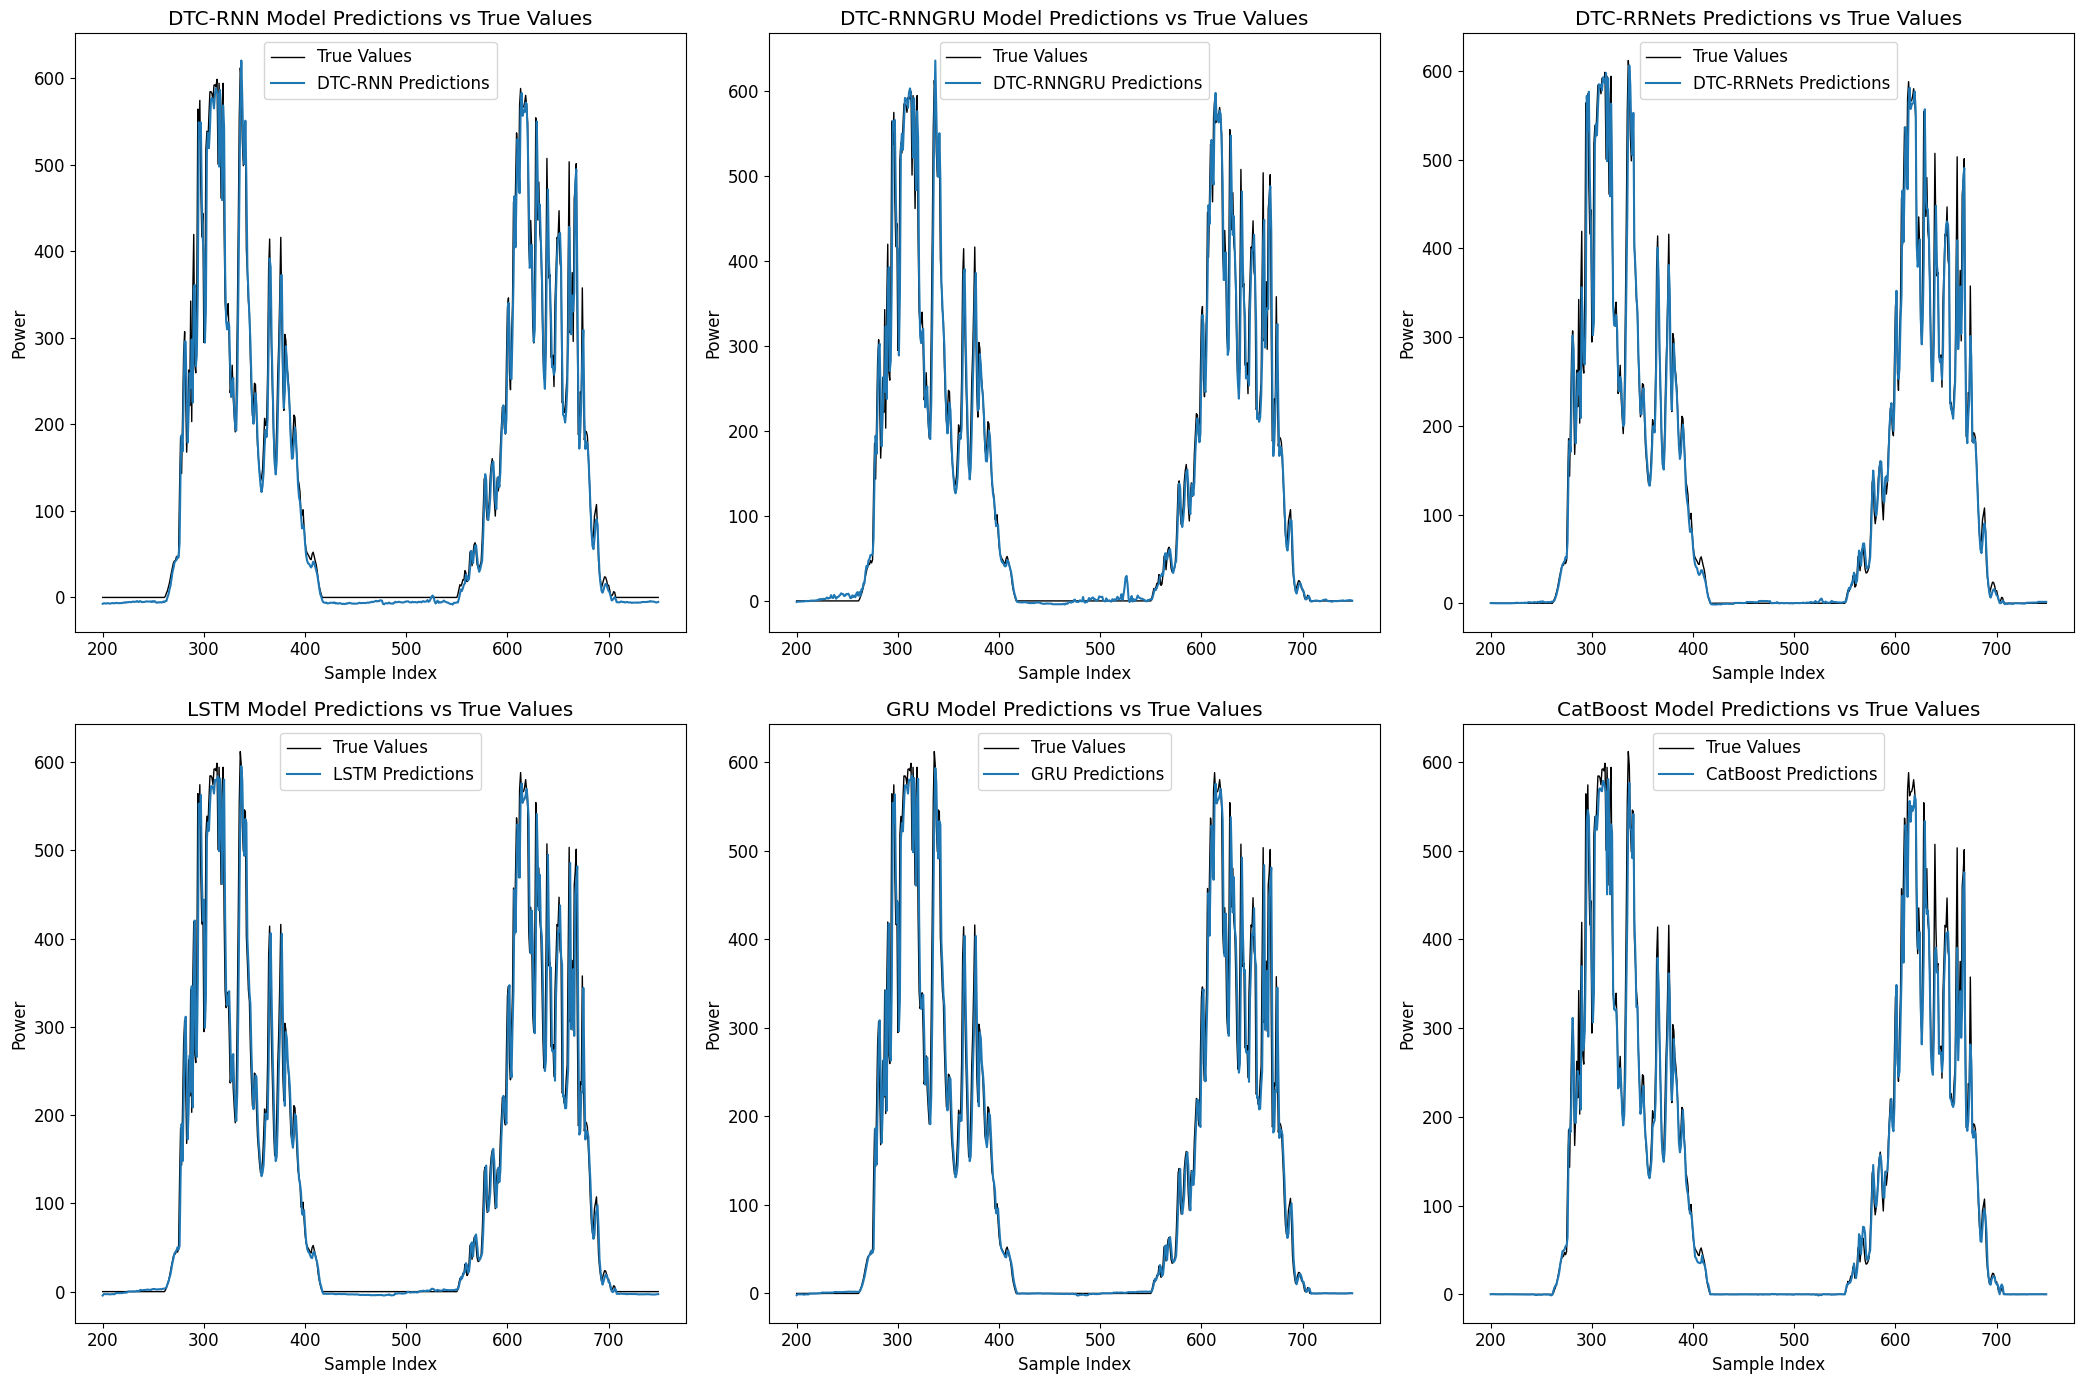

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# 读取CSV文件
predictions_df = pd.read_csv('all_model_predictions.csv')

# 显示数据以确保正确加载
print(predictions_df.head())

# 设置全局字体大小和字体类型以提高清晰度
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# 创建一个3行2列的子图结构
fig, axes = plt.subplots(2, 3, figsize=(21,14))

# 第一个图：RNN模型
axes[0, 0].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[0, 0].plot(predictions_df['LNN Predictions'][200:750], label='DTC-RNN Predictions')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Power')
axes[0, 0].set_title('DTC-RNN Model Predictions vs True Values')
axes[0, 0].legend()

# 第二个图：TCRNNGRU模型
axes[0, 1].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[0, 1].plot(predictions_df['TCLNNGRU Predictions'][200:750], label='DTC-RNNGRU Predictions')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Power')
axes[0, 1].set_title('DTC-RNNGRU Model Predictions vs True Values')
axes[0, 1].legend()

# 第三个图：残差LNNGRU模型
axes[0, 2].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[0, 2].plot(predictions_df['Residual LNNGRU Predictions'][200:750], label='DTC-RRNets Predictions')
axes[0, 2].set_xlabel('Sample Index')
axes[0, 2].set_ylabel('Power')
axes[0, 2].set_title('DTC-RRNets Predictions vs True Values')
axes[0, 2].legend()

# 第四个图：LSTM模型
axes[1, 0].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[1, 0].plot(predictions_df['LSTM Predictions'][200:750], label='LSTM Predictions')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('LSTM Model Predictions vs True Values')
axes[1, 0].legend()

# 第五个图：GRU模型
axes[1, 1].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[1, 1].plot(predictions_df['GRU Predictions'][200:750], label='GRU Predictions')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('GRU Model Predictions vs True Values')
axes[1, 1].legend()

# 第六个图：CatBoost模型
axes[1, 2].plot(predictions_df['True Values'][200:750], label='True Values', color='black', linewidth=1)
axes[1, 2].plot(predictions_df['CatBoost Predictions'][200:750], label='CatBoost Predictions')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('Power')
axes[1, 2].set_title('CatBoost Model Predictions vs True Values')
axes[1, 2].legend()

# 调整子图间的间隔
plt.tight_layout()

# 保存图像，指定DPI
plt.savefig('model_predictions_vs_true_values.png', dpi=400)

# 显示图像
plt.show()


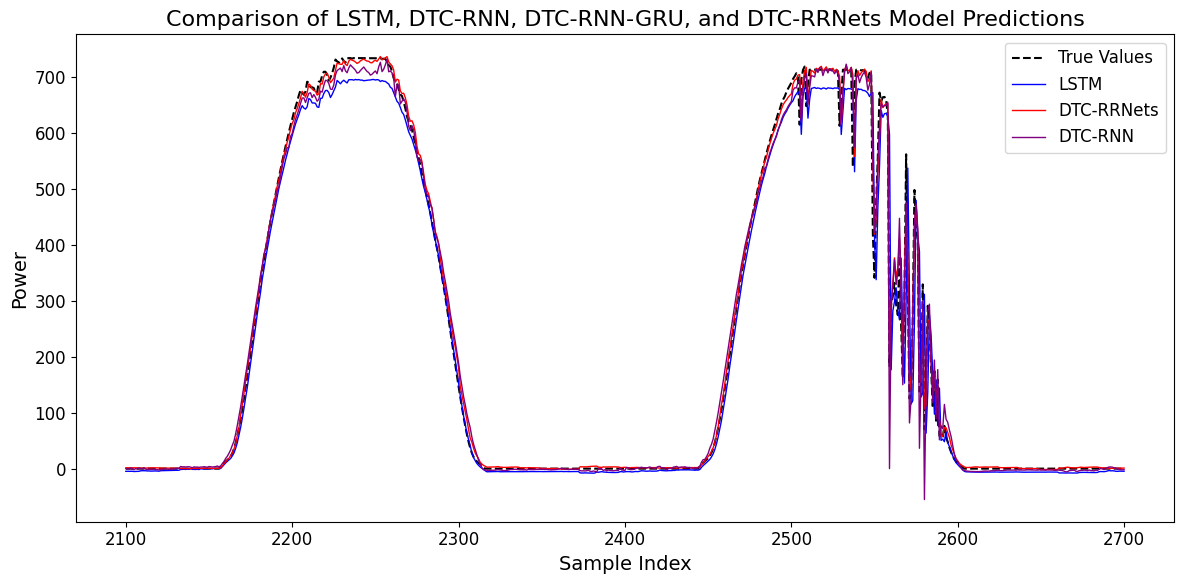

{'LSTM': {'MAE': 20.78179213785641,
  'RMSE': 42.39794591053105,
  'R²': 0.9792163689460235},
 'DTC-RRNets': {'MAE': 7.9576128650821865,
  'RMSE': 17.709854223354736,
  'R²': 0.9963737164148155},
 'DTC-RNN': {'MAE': 12.30320616888166,
  'RMSE': 22.059640355819436,
  'R²': 0.9943736253604725}}

In [10]:
import matplotlib.pyplot as plt

# Filter the data to the indices 2100-2700 for both LSTM and DTC-RRNets (Residual LNNGRU)
filtered_data = predictions_df[2100:2701]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['True Values'], label='True Values', color='black', linewidth=1.5, linestyle='--')
plt.plot(filtered_data['LSTM Predictions'], label='LSTM', color='blue', linewidth=1)
plt.plot(filtered_data['Residual LNNGRU Predictions'], label='DTC-RRNets', color='red', linewidth=1)
plt.plot(filtered_data['LNN Predictions'], label='DTC-RNN', color='purple', linewidth=1)

plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.title('Comparison of LSTM, DTC-RNN, DTC-RNN-GRU, and DTC-RRNets Model Predictions', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('model_predictions_LSTM_DTC_RNN_DTC_RNN_GRU_DTC_RRNets.jpg', dpi=300)
# Show the plot without grid lines
plt.show()

from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE, RMSE, and R^2 for the models, excluding DTC-RNNGRU
def calculate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, rmse, r2

# Metrics for LSTM
mae_lstm, rmse_lstm, r2_lstm = calculate_metrics(true_values, lstm_predictions)

# Metrics for DTC-RRNets
mae_dtc_rrnets, rmse_dtc_rrnets, r2_dtc_rrnets = calculate_metrics(true_values, dtc_rrnets_predictions)

# Metrics for DTC-RNN
mae_dtc_rnn, rmse_dtc_rnn, r2_dtc_rnn = calculate_metrics(true_values, dtc_rnn_predictions)

metrics = {
    "LSTM": {"MAE": mae_lstm, "RMSE": rmse_lstm, "R²": r2_lstm},
    "DTC-RRNets": {"MAE": mae_dtc_rrnets, "RMSE": rmse_dtc_rrnets, "R²": r2_dtc_rrnets},
    "DTC-RNN": {"MAE": mae_dtc_rnn, "RMSE": rmse_dtc_rnn, "R²": r2_dtc_rnn}
}

metrics



In [38]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
file_path = r'D:\Pythonworkshop\PV_DKA\all_model_predictions.csv'
data = pd.read_csv(file_path)
data[data < 1] = 0.01
# Assume the first column is the actual values, and the following columns are predictions
actual_values = data.iloc[:, 0]
predictions = data.iloc[:, 1:]

# Initialize a dictionary to store the results
results = {}

# Calculate the baseline model (shifted by one step)
baseline_model = actual_values.shift(1).fillna(method='bfill')  # fill the first NaN with the first actual value

# Calculate MAE, RMSE, SS-RMSE, and R² for each model
for model_name in predictions.columns:
    model_predictions = predictions[model_name]
    
    mae = mean_absolute_error(actual_values, model_predictions)
    rmse = mean_squared_error(actual_values, model_predictions, squared=False)
    baseline_rmse = mean_squared_error(actual_values, baseline_model, squared=False)
    ss_rmse = 1 - (rmse / baseline_rmse)
    r2 = r2_score(actual_values, model_predictions)
    
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'SS-RMSE': ss_rmse,
        'R²': r2
    }

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results).T
print(results_df)
#Save the results to a CSV file
results_df.to_csv('LNN_LSTM_GRU_MLP_RF_Catboost_results.csv')


                                   MAE       RMSE   SS-RMSE        R²
LNN Predictions              13.171109  29.392944  0.208695  0.983479
SVM predictions              17.510129  37.452558 -0.008283  0.973176
TCLNNGRU Predictions         15.759051  29.931834  0.194187  0.982867
Residual LNNGRU Predictions  11.576963  28.426131  0.234723  0.984548
LSTM Predictions             16.030237  36.889453  0.006876  0.973977
GRU Predictions              15.850123  36.728684  0.011205  0.974203
RandomForest Predictions     11.776370  29.646689  0.201863  0.983192
CatBoost Predictions         12.938128  30.267520  0.185150  0.982481


C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_14184\2236266879.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  baseline_model = actual_values.shift(1).fillna(method='bfill')  # fill the first NaN with the first actual value
c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\bo.chen18\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\m